In [102]:
import numpy as np
import sxs
import scipy
import gw_eccentricity
import matplotlib.pyplot as plt
import os
import sys
sys.path.insert(0, "./tools")
import loading
import decomposition
from importlib import reload
reload(loading)
reload(decomposition)

<module 'decomposition' from '/urania/u/pjn/gitrepos/EccentricWaveformDecomposition/tools/decomposition.py'>

In [2]:
IDs = [str(x).zfill(2) for x in range(1, 13)]
IDs = IDs + [str(x).zfill(2) for x in range(26, 42)]
IDs = IDs + [str(x).zfill(2) for x in range(66, 91)]

N_runs = np.size(IDs)
extrapolation_order = 2
project = "SurveyMeanAno_v2"
wfs, metadata, horizon = loading.LoadData(IDs, extrapolation_order, project)
h22 = loading.RestrictTo22and20Mode(wfs, IDs)
h22_total = loading.CutJunk(h22, IDs, junk_time=2000)
h22 = loading.RestrictToFirstPeriastron(h22, IDs)
h22 = loading.RestrictToInspiral(h22, IDs)
h22 = loading.Align(h22, IDs)
h22 = loading.AddQCData(h22)
h22 = decomposition.AddMeanAnomalyDomain(h22, IDs, periastron_definition="QC", include_ends=True)
h22 = loading.AddA22andPhi22(h22, IDs)

In [3]:
e, l = decomposition.MeasureReferenceEccandMeanAno(h22, IDs)
l_array = np.zeros(N_runs)
for i in range(N_runs):
    l_array[i] = l[IDs[i]]

/u/pjn/conda-envs/surrogate/lib/python3.12/site-packages/gw_eccentricity/eccDefinition.py:1788: UserWarning: egw(t) is nonmonotonic in the range [-226.4314956497019, -83.13149564918058]
For more verbose output use `debug_level=1`.
  debug_message(message, self.debug_level,
/u/pjn/conda-envs/surrogate/lib/python3.12/site-packages/gw_eccentricity/eccDefinition.py:1788: UserWarning: egw(t) is nonmonotonic in the range [-246.18430465283564, -98.18430465229721]
For more verbose output use `debug_level=1`.
  debug_message(message, self.debug_level,
/u/pjn/conda-envs/surrogate/lib/python3.12/site-packages/gw_eccentricity/eccDefinition.py:1788: UserWarning: egw(t) is nonmonotonic in the range [-270.3688228555566, -119.06882285500615]
For more verbose output use `debug_level=1`.
  debug_message(message, self.debug_level,
/u/pjn/conda-envs/surrogate/lib/python3.12/site-packages/gw_eccentricity/eccDefinition.py:1788: UserWarning: egw(t) is nonmonotonic in the range [-284.4939879801459, -133.49398

In [4]:
sys.path.insert(0, "/u/pjn/gitrepos/pySurrogate/master")
import pySurrogate as pySur
%matplotlib inline

In [146]:
reload(decomposition)
h22 = decomposition.AddMeanAnomalyDomain(h22, IDs, periastron_definition="QC", include_ends=True, UseSmooth=True)

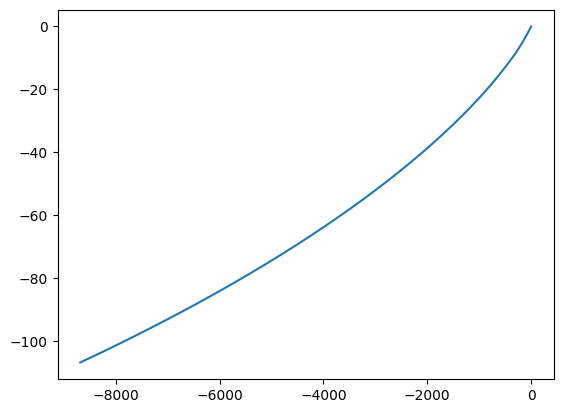

In [147]:
plt.plot(h22[IDs[2]]["t"],h22[IDs[2]]["MeanAno"])

In [160]:
# Setup the domain
h22 = decomposition.InterpolateToUniformMeanAnomalyDomain(h22, IDs, l_min=-30*np.pi, l_max=0)
meanano_domain = h22[IDs[0]]["MeanAno_uniform"]

# Make a DataModeler object as our surrogate
sur_amp = pySur.DataModeler(meanano_domain, "Amplitude_surrogate")
sur_phi = pySur.DataModeler(meanano_domain, "Phase_surrogate")
sur_t = pySur.DataModeler(meanano_domain, "Time_surrogate")

# Add the data
for i, w in enumerate(IDs):
    sur_amp.addKnownDataSet(np.array([e[w], l[w]]), h22[w]["A22_uniform"])
    sur_phi.addKnownDataSet(np.array([e[w], l[w]]), h22[w]["phi22_uniform"])
    sur_t.addKnownDataSet(np.array([e[w], l[w]]), h22[w]["t_uniform"])
    
# for i, w in enumerate(IDs):
#     sur_amp.addKnownDataSet(np.array([e[w], np.sin((np.pi-l[w])/2)]), h22[w]["A22_uniform"])
#     sur_phi.addKnownDataSet(np.array([e[w], np.sin((np.pi-l[w])/2)]), h22[w]["phi22_uniform"])
#     sur_t.addKnownDataSet(np.array([e[w], np.sin((np.pi-l[w])/2)]), h22[w]["t_uniform"])
    
plotdir='test_surrogate'
# Build a reduced basis and empirical interpolant
# The plotDir key is used to provide a folder to save emperical interpolant construction plots
sur_amp.createEmpiricalInterpolant(basisTol=1e-4, plotOpts = {'plotDir': plotdir+"_amp"})
sur_phi.createEmpiricalInterpolant(basisTol=1e-2, plotOpts = {'plotDir': plotdir+"_phi"})
sur_t.createEmpiricalInterpolant(basisTol=1e-2, plotOpts = {'plotDir': plotdir+"_t"})

# Setup fits - these options will be remembered for all fits unless we override them
sur_amp.setupFits(minVals=[0,0], maxVals=[0.3,2*np.pi], fitType='GPR')
sur_phi.setupFits(minVals=[0,0], maxVals=[0.3,2*np.pi], fitType='GPR')
sur_t.setupFits(minVals=[0,0], maxVals=[0.3,2*np.pi], fitType='GPR')

# Fit the data
sur_amp.fit()
sur_phi.fit()
sur_t.fit()

Creating a float64 pySur RB/EI from 53 data sets with tol 0.0001 for Amplitude_surrogate
...got 11 basis elements
Plotting basis for Amplitude_surrogate


/u/pjn/gitrepos/pySurrogate/master/pySurrogate/dataModeler.py:345: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(split_time, self.domain[-1])


Creating a float64 pySur RB/EI from 53 data sets with tol 0.01 for Phase_surrogate
...got 10 basis elements
Plotting basis for Phase_surrogate
Creating a float64 pySur RB/EI from 53 data sets with tol 0.01 for Time_surrogate
...got 21 basis elements
Plotting basis for Time_surrogate
Amplitude_surrogate is fitting 11 nodes


/u/pjn/conda-envs/surrogate/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/u/pjn/conda-envs/surrogate/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/u/pjn/conda-envs/surrogate/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/u/pjn/conda-envs/surrogate/lib/python3.12/site-p

Phase_surrogate is fitting 10 nodes


/u/pjn/conda-envs/surrogate/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/u/pjn/conda-envs/surrogate/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/u/pjn/conda-envs/surrogate/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/u/pjn/conda-envs/surrogate/lib/python3.12/site-p

Time_surrogate is fitting 21 nodes


/u/pjn/conda-envs/surrogate/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/u/pjn/conda-envs/surrogate/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/u/pjn/conda-envs/surrogate/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/u/pjn/conda-envs/surrogate/lib/python3.12/site-p

In [161]:
err = np.zeros(np.size(IDs))
for i, w in enumerate(IDs):
    exact_sol = h22[w]["A22_uniform"]
    sur_eval = sur_amp(np.array([e[w], l[w]]))
    err[i] = max(abs(exact_sol - sur_eval))
    
print(f'Max training space LInf error: {max(err)} at {IDs[np.argmax(err)]}')


err = np.zeros(np.size(IDs))
for i, w in enumerate(IDs):
    exact_sol = h22[w]["phi22_uniform"]
    sur_eval = sur_phi(np.array([e[w], l[w]]))
    err[i] = max(abs(exact_sol - sur_eval))
    
print(f'Max training space LInf error: {max(err)} at {IDs[np.argmax(err)]}')
err = np.zeros(np.size(IDs))
for i, w in enumerate(IDs):
    exact_sol = h22[w]["t_uniform"]
    sur_eval = sur_t(np.array([e[w], l[w]]))
    err[i] = max(abs(exact_sol - sur_eval))
    
print(f'Max training space LInf error: {max(err)} at {IDs[np.argmax(err)]}')

# err = np.zeros(np.size(IDs))
# for i, w in enumerate(IDs):
#     exact_sol = h22[w]["A22_uniform"]
#     sur_eval = sur_amp(np.array([e[w], np.sin((np.pi-l[w])/2)]))
#     err[i] = max(abs(exact_sol - sur_eval))
    
# print(f'Max training space LInf error: {max(err)} at {IDs[np.argmax(err)]}')


# err = np.zeros(np.size(IDs))
# for i, w in enumerate(IDs):
#     exact_sol = h22[w]["phi22_uniform"]
#     sur_eval = sur_phi(np.array([e[w], np.sin((np.pi-l[w])/2)]))
#     err[i] = max(abs(exact_sol - sur_eval))
    
# print(f'Max training space LInf error: {max(err)} at {IDs[np.argmax(err)]}')
# err = np.zeros(np.size(IDs))
# for i, w in enumerate(IDs):
#     exact_sol = h22[w]["t_uniform"]
#     sur_eval = sur_t(np.array([e[w], np.sin((np.pi-l[w])/2)]))
#     err[i] = max(abs(exact_sol - sur_eval))
    
# print(f'Max training space LInf error: {max(err)} at {IDs[np.argmax(err)]}')

Max training space LInf error: 0.001398407067560753 at 09
Max training space LInf error: 0.09044135561245525 at 11
Max training space LInf error: 2.7022173902669238 at 29


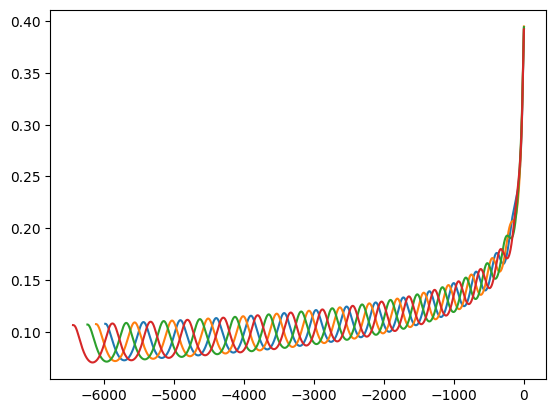

In [163]:
for l0 in np.linspace(0, 2*np.pi, 4, endpoint=False):
    sur_eval_A = sur_amp(np.array([0.1, l0]))
    sur_eval_t = sur_t(np.array([0.1, l0]))
    plt.plot(sur_eval_t, sur_eval_A)
plt.show()

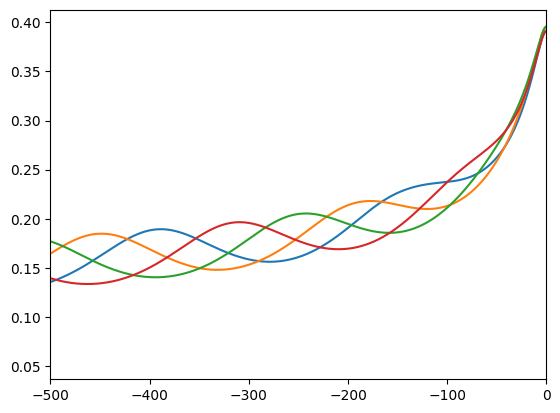

In [165]:
for l0 in np.linspace(0, 2*np.pi, 4, endpoint=False):
    sur_eval_A = sur_amp(np.array([0.2, l0]))
    sur_eval_t = sur_t(np.array([0.2, l0]))
    plt.plot(sur_eval_t, sur_eval_A)
plt.xlim(-500, 0)
plt.show()

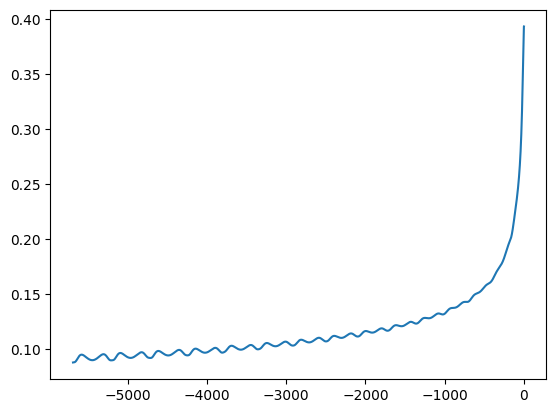

In [166]:
sur_eval_A = sur_amp(np.array([0., 0]))
sur_eval_t = sur_t(np.array([0., 0]))
plt.plot(sur_eval_t, sur_eval_A)
plt.show()

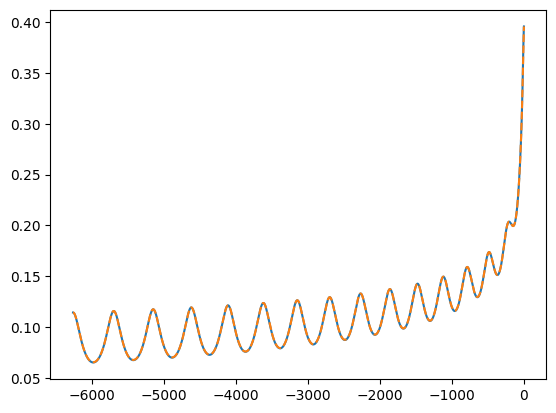

In [168]:
sur_eval_A = sur_amp(np.array([e["41"],l["41"]]))
sur_eval_t = sur_t(np.array([e["41"], l["41"]]))
plt.plot(h22["41"]["t_uniform"], h22["41"]["A22_uniform"])
plt.plot(sur_eval_t, sur_eval_A, '--')
plt.show()

0.0
0.0
0.0
0.0
0.0


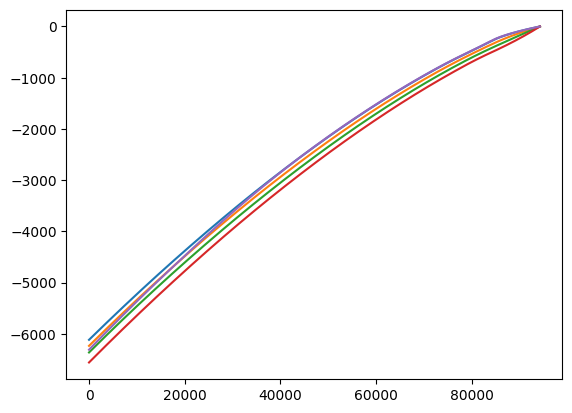

In [169]:
for l0 in np.linspace(0, 2*np.pi, 5):
    sur_eval_t = sur_t(np.array([0.15, l0]))
    plt.plot(sur_eval_t)
    print(sur_eval_t[-1])

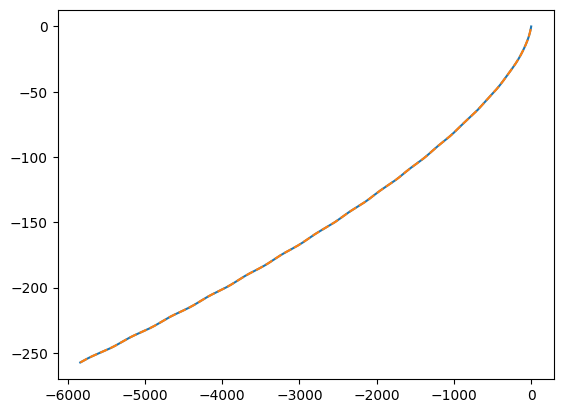

In [170]:
sur_eval_A = sur_phi(np.array([e["77"], l["77"]]))
sur_eval_t = sur_t(np.array([e["77"], l["77"]]))
plt.plot(h22["77"]["t_uniform"], h22["77"]["phi22_uniform"])
plt.plot(sur_eval_t, sur_eval_A, '--')
plt.show()

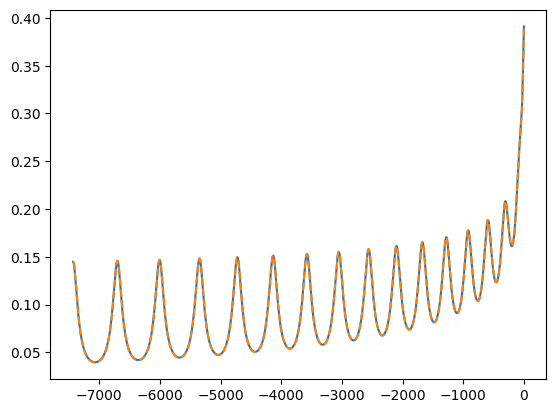

In [171]:
sur_eval_A = sur_amp(np.array([e["08"], l["08"]]))
sur_eval_t = sur_t(np.array([e["08"], l["08"]]))
plt.plot(h22["08"]["t_uniform"], h22["08"]["A22_uniform"])
plt.plot(sur_eval_t, sur_eval_A, '--')
plt.show()

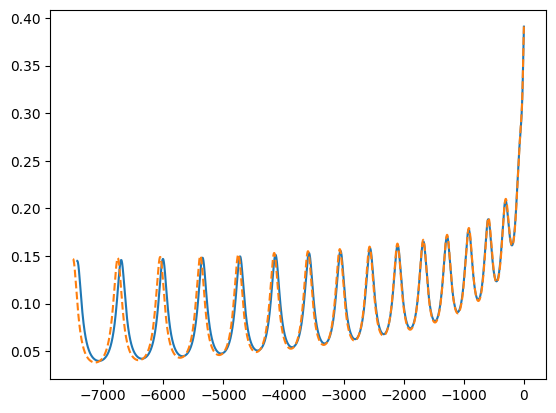

In [174]:
sur_eval_A = sur_amp(np.array([e["08"]+1e-2, l["08"]]))
sur_eval_t = sur_t(np.array([e["08"]+1e-2, l["08"]]))
plt.plot(h22["08"]["t_uniform"], h22["08"]["A22_uniform"])
plt.plot(sur_eval_t, sur_eval_A, '--')
plt.show()

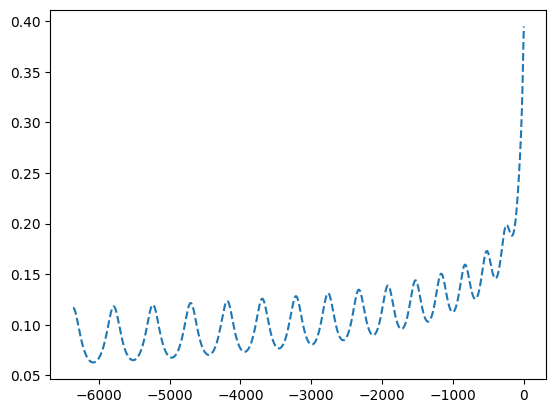

In [175]:
sur_eval_A = sur_amp(np.array([0.15, np.pi]))
sur_eval_t = sur_t(np.array([0.15, np.pi]))
plt.plot(sur_eval_t, sur_eval_A, '--')

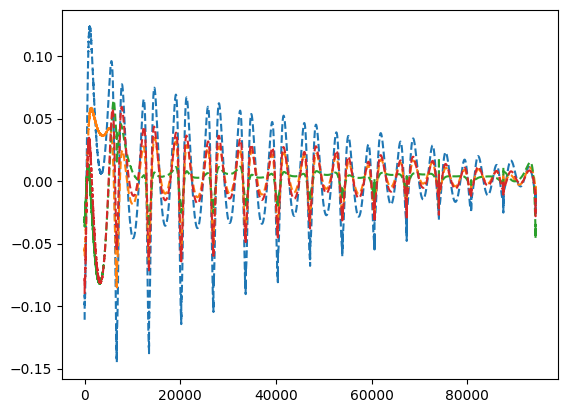

In [89]:
for l0 in np.linspace(0, 2*np.pi, 4):
    sur_eval_A = sur_phi(np.array([0.1, l0]))
    plt.plot(np.diff(sur_eval_A), '--')

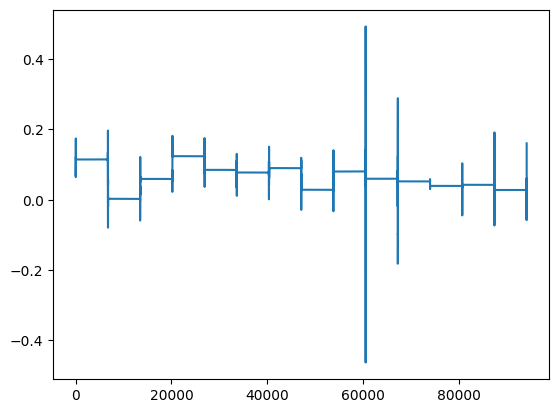

In [60]:
plt.plot(np.diff(sur_t(np.array([0.15, l0]))))

In [91]:
e

{'01': 0.2875392554790269,
 '02': 0.28696941301543144,
 '03': 0.28652067547315907,
 '04': 0.2861094471424819,
 '05': 0.28636776779134554,
 '06': 0.28671696110527045,
 '07': 0.28663348704159197,
 '08': 0.2869066055176087,
 '09': 0.28702477960500683,
 '10': 0.2873927253095033,
 '11': 0.2873193127143454,
 '12': 0.28696795197317704,
 '26': 0.2735231524638483,
 '27': 0.27360388727759477,
 '28': 0.2736147172060772,
 '29': 0.2736022040768651,
 '30': 0.13568786895926044,
 '31': 0.135718831551622,
 '32': 0.1357375271217296,
 '33': 0.13576351793926034,
 '34': 0.13582163537873448,
 '35': 0.13584203721381471,
 '36': 0.13584559363663207,
 '37': 0.13585012042771505,
 '38': 0.13582809137792462,
 '39': 0.13609935803149675,
 '40': 0.13625183142037978,
 '41': 0.13623877310416777,
 '66': 0.06757783757778257,
 '67': 0.06757672660631042,
 '68': 0.06757033989553651,
 '69': 0.06756274278424779,
 '70': 0.06773706933468449,
 '71': 0.06777700821887678,
 '72': 0.06768680723741116,
 '73': 0.06766449635643479,
 '7

In [92]:
np.linspace(0, 2*np.pi, 4)

array([0.        , 2.0943951 , 4.1887902 , 6.28318531])

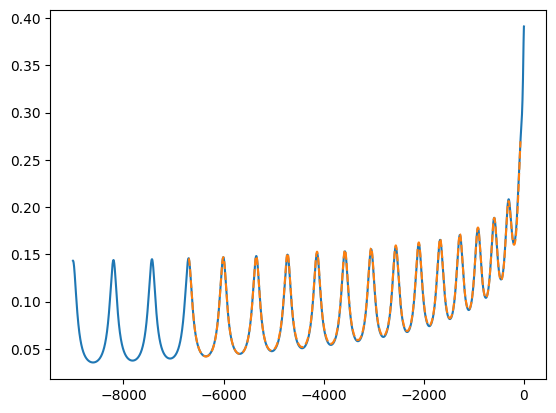

In [93]:
sur_eval_A = sur_amp(np.array([e["08"], l["08"]]))
sur_eval_t = sur_t(np.array([e["08"], l["08"]]))
plt.plot(h22["08"]["t"], np.abs(h22["08"]["h22"]))
plt.plot(sur_eval_t, sur_eval_A, '--')
plt.show()

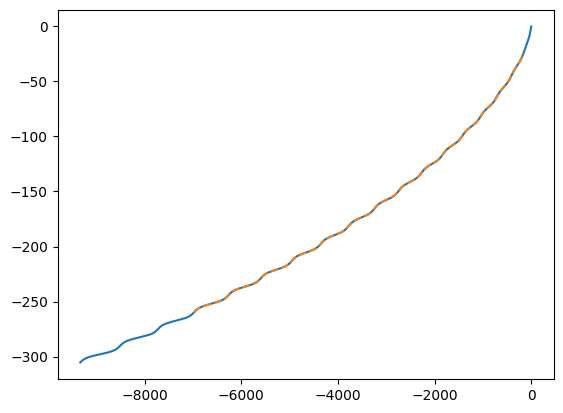

In [94]:
sur_eval_A = sur_phi(np.array([e["01"], l["01"]]))
sur_eval_t = sur_t(np.array([e["01"], l["01"]]))
plt.plot(h22[IDs[0]]["t"], h22[IDs[0]]["phi22"])
plt.plot(sur_eval_t, sur_eval_A, '--')
# plt.xlim(-2000, 0)
plt.show()

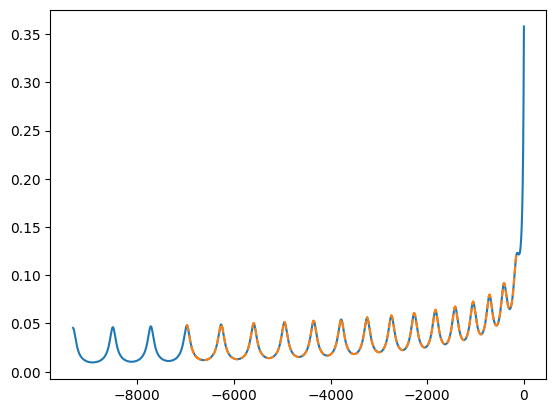

In [95]:
sur_eval_A = sur_phi(np.array([e["01"], l["01"]]))
sur_eval_t = sur_t(np.array([e["01"], l["01"]]))
plt.plot(h22[IDs[0]]["t"][:-1], np.diff(h22[IDs[0]]["phi22"])/np.diff(h22[IDs[0]]["t"]))
plt.plot(sur_eval_t[:-1], np.diff(sur_eval_A)/np.diff(sur_eval_t), '--')
# plt.xlim(-2000, 0)
plt.show()

In [96]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors
norm = mcolors.Normalize(vmin=0, vmax=2*np.pi)
mappable = cm.ScalarMappable(norm=norm, cmap='twilight')

In [102]:
np.size(IDs)

100

In [100]:
h22[IDs[105]]

IndexError: list index out of range

Text(0, 0.5, 'A22')

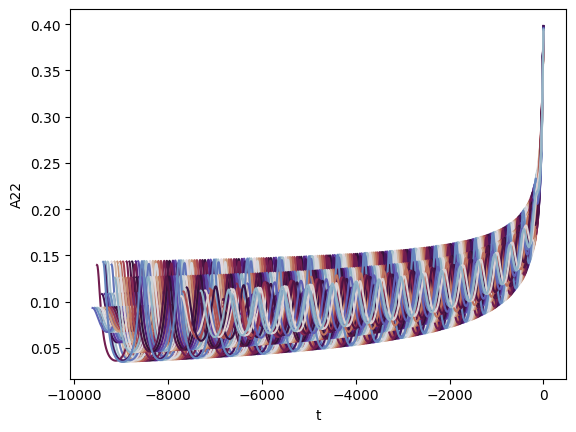

In [103]:
for k in range(100):
    plt.plot(h22[IDs[k]]["t"], np.abs(h22[IDs[k]]["h22"]), color=mappable.to_rgba(l[IDs[k]]))
plt.xlabel("t")
# plt.plot(h22["QC"]["t"], np.abs(h22["QC"]["h22"]))
plt.ylabel("A22")

In [104]:
A22_QC = np.abs(h22["QC"]["h22"])
t_QC = h22["QC"]["t"]
A22_QC_interp = scipy.interpolate.interp1d(t_QC, A22_QC)

(-100.0, 0.0)

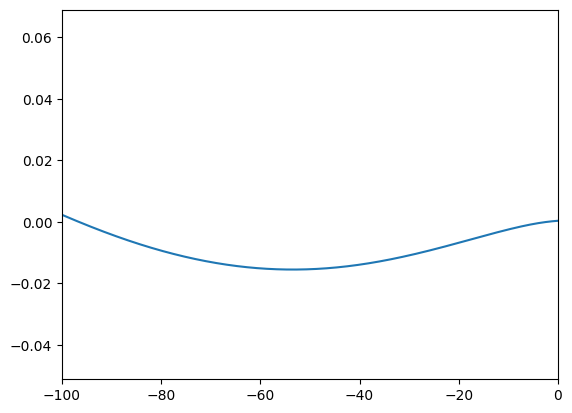

In [105]:
plt.plot(h22[IDs[0]]["t"], np.abs(h22[IDs[0]]["h22"])-A22_QC_interp(h22[IDs[0]]["t"]))
plt.xlim(-100, 0)

(-1000.0, 0.0)

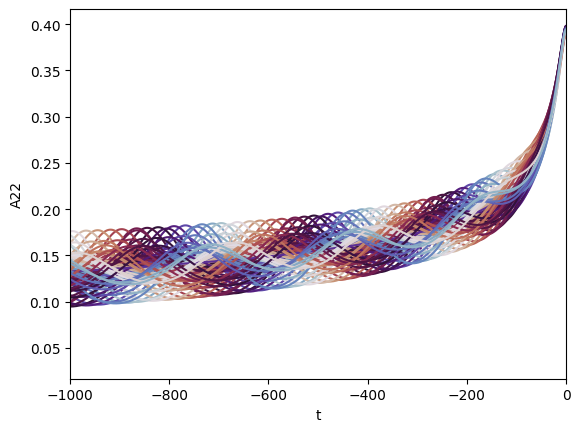

In [109]:
for k in range(100):
    plt.plot(h22[IDs[k]]["t"], np.abs(h22[IDs[k]]["A22"]), color=mappable.to_rgba(l[IDs[k]]))
plt.xlabel("t")
plt.ylabel("A22")
plt.xlim(-1000, 0)

<>:4: SyntaxWarning: invalid escape sequence '\e'
<>:4: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_68620/1482798466.py:4: SyntaxWarning: invalid escape sequence '\e'
  plt.ylabel("$\ell$")


Text(0, 0.5, '$\\ell$')

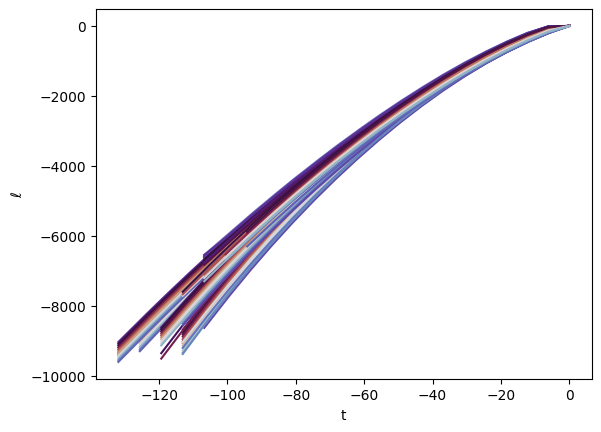

In [107]:
for k in range(100):
    plt.plot(h22[IDs[k]]["MeanAno"], h22[IDs[k]]["t"], color=mappable.to_rgba(l[IDs[k]]))
plt.xlabel("t")
plt.ylabel("$\ell$")

<>:4: SyntaxWarning: invalid escape sequence '\e'
<>:4: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_68620/3545349925.py:4: SyntaxWarning: invalid escape sequence '\e'
  plt.ylabel("$\ell$")


(0.0, -250.0)

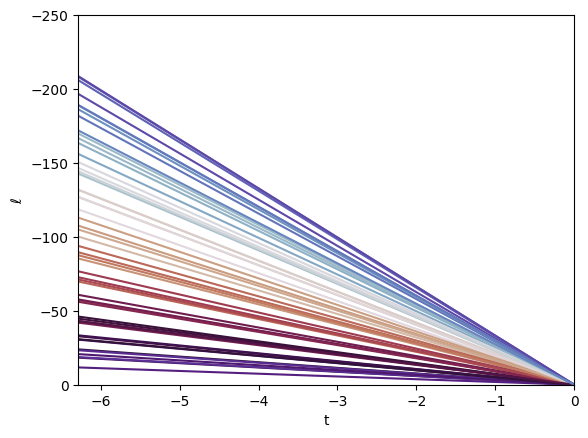

In [25]:
for k in range(N_runs):
    plt.plot(h22[IDs[k]]["MeanAno"], h22[IDs[k]]["t"], color=mappable.to_rgba(l[IDs[k]]))
plt.xlabel("t")
plt.ylabel("$\ell$")
plt.xlim(-2*np.pi, 0)
plt.ylim(0, -250)

<>:4: SyntaxWarning: invalid escape sequence '\e'
<>:4: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_68620/2932975296.py:4: SyntaxWarning: invalid escape sequence '\e'
  plt.ylabel("$\ell$")


(-5500.0, -3500.0)

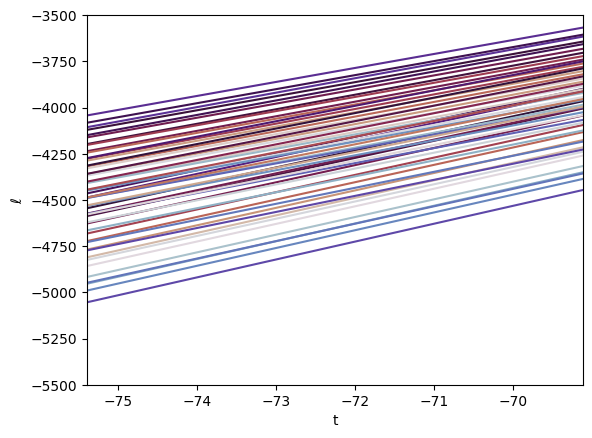

In [26]:
for k in range(N_runs):
    plt.plot(h22[IDs[k]]["MeanAno"], h22[IDs[k]]["t"], color=mappable.to_rgba(l[IDs[k]]))
plt.xlabel("t")
plt.ylabel("$\ell$")
plt.xlim(-24*np.pi, -22*np.pi)
plt.ylim(-5500, -3500)


<>:3: SyntaxWarning: invalid escape sequence '\e'
<>:3: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_68620/235992917.py:3: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel("$\ell$")


Text(0, 0.5, 'A22')

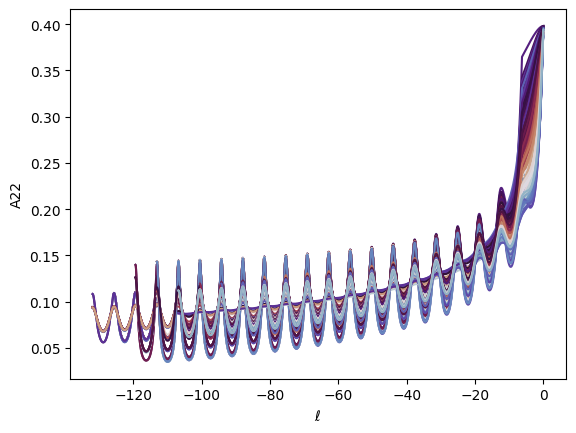

In [110]:
for k in range(100):
    plt.plot(h22[IDs[k]]["MeanAno"], h22[IDs[k]]["A22"], color=mappable.to_rgba(l[IDs[k]]))
plt.xlabel("$\ell$")
plt.ylabel("A22")

<>:3: SyntaxWarning: invalid escape sequence '\e'
<>:3: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_68620/3766935268.py:3: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel("$\ell$")


(-6.283185307179586, 0.0)

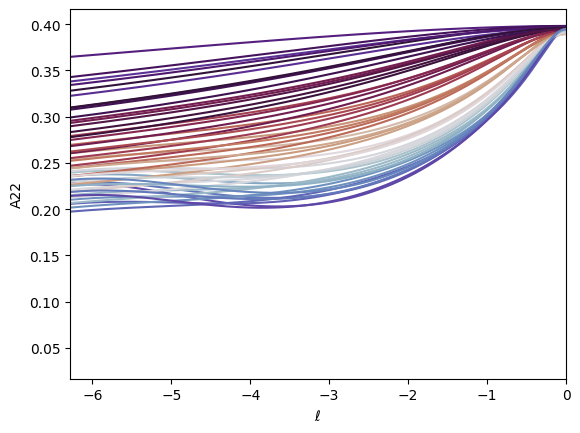

In [28]:
for k in range(N_runs):
    plt.plot(h22[IDs[k]]["MeanAno"], np.abs(h22[IDs[k]]["h22"]), color=mappable.to_rgba(l[IDs[k]]))
plt.xlabel("$\ell$")
plt.ylabel("A22")
plt.xlim(-2*np.pi, 0)

<>:3: SyntaxWarning: invalid escape sequence '\e'
<>:3: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_68620/1488995655.py:3: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel("$\ell$")


(0.04, 0.16)

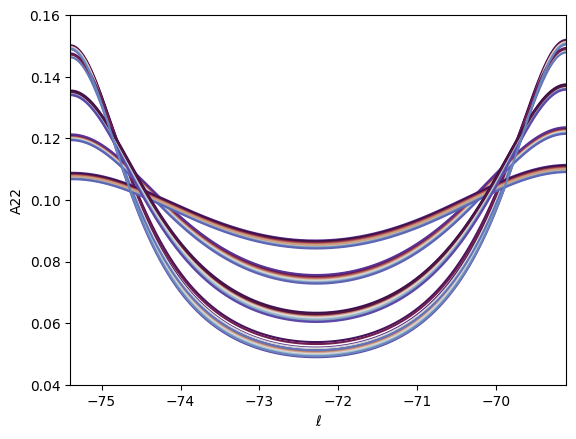

In [29]:
for k in range(N_runs):
    plt.plot(h22[IDs[k]]["MeanAno"], np.abs(h22[IDs[k]]["h22"]), color=mappable.to_rgba(l[IDs[k]]))
plt.xlabel("$\ell$")
plt.ylabel("A22")
plt.xlim(-24*np.pi, -22*np.pi)
plt.ylim(0.04, 0.16)

<>:3: SyntaxWarning: invalid escape sequence '\e'
<>:3: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_68620/1056989981.py:3: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel("$\ell$")


(0.04, 0.06)

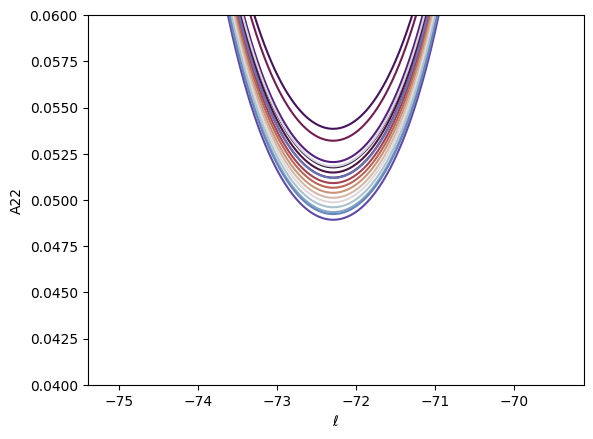

In [30]:
for k in range(N_runs):
    plt.plot(h22[IDs[k]]["MeanAno"], np.abs(h22[IDs[k]]["h22"]), color=mappable.to_rgba(l[IDs[k]]))
plt.xlabel("$\ell$")
plt.ylabel("A22")
plt.xlim(-24*np.pi, -22*np.pi)
plt.ylim(0.04, 0.16)
plt.ylim(0.04, 0.06)

<>:3: SyntaxWarning: invalid escape sequence '\e'
<>:3: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_68620/761300049.py:3: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel("$\ell$")


Text(0, 0.5, 'phi22')

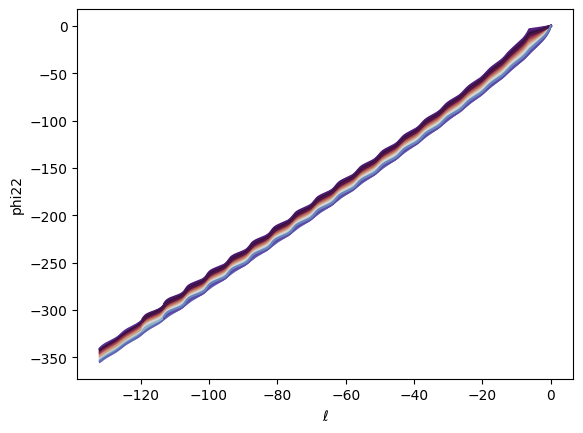

In [31]:
for k in range(N_runs):
    plt.plot(h22[IDs[k]]["MeanAno"], h22[IDs[k]]["phi22"], color=mappable.to_rgba(l[IDs[k]]))
plt.xlabel("$\ell$")
plt.ylabel("phi22")

<>:3: SyntaxWarning: invalid escape sequence '\e'
<>:3: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_68620/1668544952.py:3: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel("$\ell$")


(-40.0, 0.0)

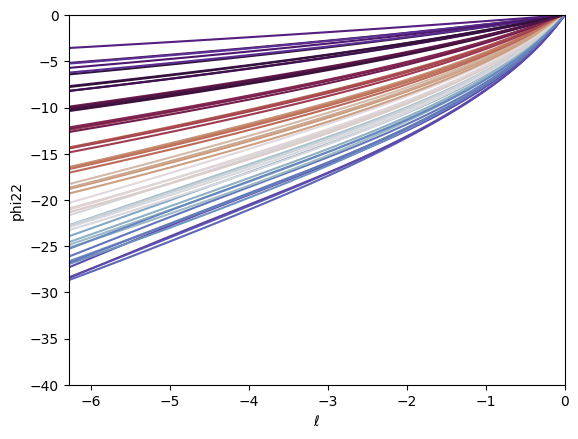

In [32]:
for k in range(N_runs):
    plt.plot(h22[IDs[k]]["MeanAno"], h22[IDs[k]]["phi22"], color=mappable.to_rgba(l[IDs[k]]))
plt.xlabel("$\ell$")
plt.ylabel("phi22")
plt.xlim(-2*np.pi, 0)
plt.ylim(-40, 0)

<>:3: SyntaxWarning: invalid escape sequence '\e'
<>:3: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_68620/3105511569.py:3: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel("$\ell$")


(-110.0, -70.0)

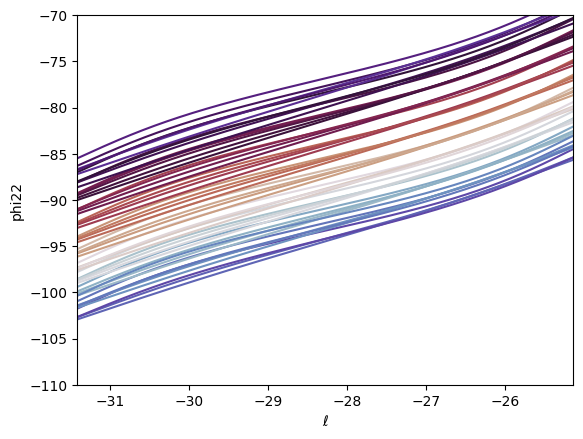

In [33]:
for k in range(N_runs):
    plt.plot(h22[IDs[k]]["MeanAno"], h22[IDs[k]]["phi22"], color=mappable.to_rgba(l[IDs[k]]))
plt.xlabel("$\ell$")
plt.ylabel("phi22")
plt.xlim(-10*np.pi, -8*np.pi)
plt.ylim(-110, -70)